In [1]:
import logging
import time
import os
import pickle
import math

import matplotlib.pyplot as plt

#import tensorflow_datasets as tfds
import tensorflow as tf

# Import tf_text to load the ops used by the tokenizer saved model
#import tensorflow_text  # pylint: disable=unused-import
import pandas as pd
import numpy as np
import re
import seaborn as sns

from sklearn.model_selection import train_test_split

import jellyfish 
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Model,  Sequential
from tensorflow.keras.layers import LSTM, GRU, Bidirectional, Dropout, Input, TimeDistributed, Dense, Activation, RepeatVector, Embedding, Concatenate
import tensorflow.keras.layers as layers
from tensorflow.keras.layers import Attention
from tensorflow.keras.optimizers import Adam, Adagrad
from keras.losses import sparse_categorical_crossentropy
logging.getLogger('tensorflow').setLevel(logging.ERROR)  # suppress warnings
import random

In [2]:
Pich_GS = pd.read_excel("./GS_Properties/Pichia_GenomeScore.xlsx")
Data = pd.read_excel("./GS_Properties/52protein_Pichia.xlsx").iloc[:,1:]
Mol_List = list(Data['Molecules'])
Test_Score = Data.iloc[:,0:]


In [3]:
def adjacent_values(vals, q1, q3):
    upper_adjacent_value = q3 + (q3 - q1) * 1.5
    upper_adjacent_value = np.clip(upper_adjacent_value, q3, vals[-1])

    lower_adjacent_value = q1 - (q3 - q1) * 1.5
    lower_adjacent_value = np.clip(lower_adjacent_value, vals[0], q1)
    return lower_adjacent_value, upper_adjacent_value

<Figure size 216x216 with 0 Axes>

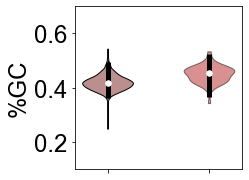

<Figure size 216x216 with 0 Axes>

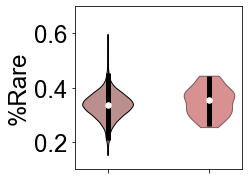

<Figure size 216x216 with 0 Axes>

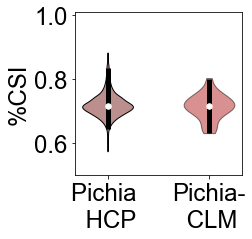

In [6]:
Prop_names = ['%GC', '%Rare', '%CSI']
for prop_id in np.arange(1,4):
    start_id = prop_id
    end_id = prop_id + 1
    
    plt.figure()
    params = {'axes.titlesize': 24, 'xtick.labelsize': 24, 'ytick.labelsize': 24, 'axes.labelsize': 24}
    hfont = {'fontname':'Arial'} #, 'weight' : 'bold'
    plt.rcParams.update(params)
    plt.rcParams["figure.figsize"] = (3, 3)
    f, ax = plt.subplots(1, 1)

    import matplotlib.font_manager as font_manager
    font = font_manager.FontProperties(family='Arial',
                                       weight='normal',
                                    style='normal', size=18)


    parts = ax.violinplot(Pich_GS.iloc[:,start_id:end_id],positions = [1], showmeans=False, showmedians=False,
        showextrema=False)
    cnt = 0
    alpha_list = [1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]
    for pc in parts['bodies']:
        print(pc)
        if cnt == 0:
            pc.set_facecolor('rosybrown')
            pc.set_edgecolor('black')
            pc.set_alpha(1.0)
            cnt = cnt+1
    quartile1, medians, quartile3 = np.percentile(np.transpose(Pich_GS.iloc[:,start_id:end_id]), [1, 50, 99], axis=1)
    whiskers = np.array([adjacent_values(sorted_array, q1, q3)
        for sorted_array, q1, q3 in zip(Pich_GS.iloc[:,start_id:end_id].values, quartile1, quartile3)])

    whiskers_min, whiskers_max = whiskers[:, 0], whiskers[:, 1]
    inds = np.arange(1, len(medians) + 1)
    ax.scatter(inds, medians, marker='o', color='white', s=30, zorder=3,label='_nolegend_')
    ax.vlines(inds, quartile1, quartile3, color='k', linestyle='-', lw=5,label='_nolegend_')
    ax.vlines(inds, whiskers_min, whiskers_max, color='k', linestyle='-', lw=1,label='_nolegend_')
    

    parts = ax.violinplot(Test_Score.iloc[:,start_id:end_id],positions = [2], showmeans=False, showmedians=False,
        showextrema=False)
    cnt = 0
    alpha_list = [1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]
    for pc in parts['bodies']:
        print(pc)
        if cnt == 0:
            pc.set_facecolor('firebrick')
            pc.set_edgecolor('black')
            pc.set_alpha(0.5)
            cnt = cnt+1
    quartile1, medians, quartile3 = np.percentile(np.transpose(Test_Score.iloc[:,start_id:end_id]), [1, 50, 99], axis=1)
    whiskers = np.array([adjacent_values(sorted_array, q1, q3)
        for sorted_array, q1, q3 in zip(Test_Score.iloc[:,start_id:end_id].values, quartile1, quartile3)])

    whiskers_min, whiskers_max = whiskers[:, 0], whiskers[:, 1]
    inds = 1+ np.arange(1, len(medians) + 1)
    ax.scatter(inds, medians, marker='o', color='white', s=30, zorder=3,label='_nolegend_')
    ax.vlines(inds, quartile1, quartile3, color='k', linestyle='-', lw=5,label='_nolegend_')
    ax.vlines(inds, whiskers_min, whiskers_max, color='k', linestyle='-', lw=1,label='_nolegend_')
    if prop_id == 3:
        ax.set_ylim([0.5, 1.01])
        ax.set_yticks([0.6,  0.8, 1.0])
        ax.set_yticklabels([0.6,  0.8, 1.0], **hfont)
    else:
        ax.set_ylim([0.1, 0.7])
        ax.set_yticks([0.2, 0.4, 0.6])
        ax.set_yticklabels([0.2, 0.4, 0.6], **hfont)
    
    ax.set_xticks([1, 2])
    if Prop_names[prop_id-1] == '%CSI':
    
        ax.set_xticklabels(['Pichia \n HCP', 'Pichia-\n CLM'], **hfont)
    else:
        ax.set_xticklabels([], **hfont)
    
    ax.set_ylabel(Prop_names[prop_id-1], **hfont)
    
    plt.savefig("./Plots/52proteins/"+Prop_names[prop_id-1]+".pdf",dpi=600, bbox_inches = "tight")

In [ ]:
# plt.figure()
# params = {'axes.titlesize': 24, 'xtick.labelsize': 24, 'ytick.labelsize': 24, 'axes.labelsize': 24}
# hfont = {'fontname':'Arial'} #, 'weight' : 'bold'
# plt.rcParams.update(params)
# plt.rcParams["figure.figsize"] = (8, 3)
# f, ax = plt.subplots(1, 2)

# import matplotlib.font_manager as font_manager
# font = font_manager.FontProperties(family='Arial',
#                                    weight='normal',
#                                 style='normal', size=18)


# parts = ax[0].violinplot(Pich_GS.iloc[:,1:2],showmeans=False, showmedians=False,
#     showextrema=False)
# cnt = 0
# alpha_list = [1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]
# for pc in parts['bodies']:
#     print(pc)
#     if cnt == 0:
#         pc.set_facecolor('rosybrown')
#         pc.set_edgecolor('black')
#         pc.set_alpha(1.0)
#         cnt = cnt+1
# quartile1, medians, quartile3 = np.percentile(np.transpose(Pich_GS.iloc[:,1:2]), [1, 50, 99], axis=1)
# whiskers = np.array([adjacent_values(sorted_array, q1, q3)
#     for sorted_array, q1, q3 in zip(Pich_GS.iloc[:,1:2].values, quartile1, quartile3)])

# whiskers_min, whiskers_max = whiskers[:, 0], whiskers[:, 1]
# inds = np.arange(1, len(medians) + 1)
# ax[0].scatter(inds, medians, marker='o', color='white', s=30, zorder=3,label='_nolegend_')
# ax[0].vlines(inds, quartile1, quartile3, color='k', linestyle='-', lw=5,label='_nolegend_')
# ax[0].vlines(inds, whiskers_min, whiskers_max, color='k', linestyle='-', lw=1,label='_nolegend_')
# ax[0].set_ylim([0.2, 0.6])

# parts = ax[1].violinplot(Test_Score.iloc[:,1:2],showmeans=False, showmedians=False,
#     showextrema=False)
# cnt = 0
# alpha_list = [1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]
# for pc in parts['bodies']:
#     print(pc)
#     if cnt == 0:
#         pc.set_facecolor('rosybrown')
#         pc.set_edgecolor('black')
#         pc.set_alpha(1.0)
#         cnt = cnt+1
# quartile1, medians, quartile3 = np.percentile(np.transpose(Test_Score.iloc[:,1:2]), [1, 50, 99], axis=1)
# whiskers = np.array([adjacent_values(sorted_array, q1, q3)
#     for sorted_array, q1, q3 in zip(Test_Score.iloc[:,1:2].values, quartile1, quartile3)])

# whiskers_min, whiskers_max = whiskers[:, 0], whiskers[:, 1]
# inds = np.arange(1, len(medians) + 1)
# ax[1].scatter(inds, medians, marker='o', color='white', s=30, zorder=3,label='_nolegend_')
# ax[1].vlines(inds, quartile1, quartile3, color='k', linestyle='-', lw=5,label='_nolegend_')
# ax[1].vlines(inds, whiskers_min, whiskers_max, color='k', linestyle='-', lw=1,label='_nolegend_')
# ax[1].set_ylim([0.2, 0.6])

In [ ]:
# plt.figure()
# params = {'axes.titlesize': 24, 'xtick.labelsize': 24, 'ytick.labelsize': 24, 'axes.labelsize': 24}
# hfont = {'fontname':'Arial'} #, 'weight' : 'bold'
# plt.rcParams.update(params)
# plt.rcParams["figure.figsize"] = (8, 3)
# f, ax = plt.subplots(1, 2)

# import matplotlib.font_manager as font_manager
# font = font_manager.FontProperties(family='Arial',
#                                    weight='normal',
#                                 style='normal', size=18)


# parts = ax[0].violinplot(Pich_GS.iloc[:,2:3],showmeans=False, showmedians=False,
#     showextrema=False)
# cnt = 0
# alpha_list = [1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]
# for pc in parts['bodies']:
#     print(pc)
#     if cnt == 0:
#         pc.set_facecolor('rosybrown')
#         pc.set_edgecolor('black')
#         pc.set_alpha(1.0)
#         cnt = cnt+1
# quartile1, medians, quartile3 = np.percentile(np.transpose(Pich_GS.iloc[:,2:3]), [1, 50, 99], axis=1)
# whiskers = np.array([adjacent_values(sorted_array, q1, q3)
#     for sorted_array, q1, q3 in zip(Pich_GS.iloc[:,2:3].values, quartile1, quartile3)])

# whiskers_min, whiskers_max = whiskers[:, 0], whiskers[:, 1]
# inds = np.arange(1, len(medians) + 1)
# ax[0].scatter(inds, medians, marker='o', color='white', s=30, zorder=3,label='_nolegend_')
# ax[0].vlines(inds, quartile1, quartile3, color='k', linestyle='-', lw=5,label='_nolegend_')
# ax[0].vlines(inds, whiskers_min, whiskers_max, color='k', linestyle='-', lw=1,label='_nolegend_')
# ax[0].set_ylim([0.2, 0.6])

# parts = ax[1].violinplot(Test_Score.iloc[:,2:3],showmeans=False, showmedians=False,
#     showextrema=False)
# cnt = 0
# alpha_list = [1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]
# for pc in parts['bodies']:
#     print(pc)
#     if cnt == 0:
#         pc.set_facecolor('rosybrown')
#         pc.set_edgecolor('black')
#         pc.set_alpha(1.0)
#         cnt = cnt+1
# quartile1, medians, quartile3 = np.percentile(np.transpose(Test_Score.iloc[:,2:3]), [1, 50, 99], axis=1)
# whiskers = np.array([adjacent_values(sorted_array, q1, q3)
#     for sorted_array, q1, q3 in zip(Test_Score.iloc[:,2:3].values, quartile1, quartile3)])

# whiskers_min, whiskers_max = whiskers[:, 0], whiskers[:, 1]
# inds = np.arange(1, len(medians) + 1)
# ax[1].scatter(inds, medians, marker='o', color='white', s=30, zorder=3,label='_nolegend_')
# ax[1].vlines(inds, quartile1, quartile3, color='k', linestyle='-', lw=5,label='_nolegend_')
# ax[1].vlines(inds, whiskers_min, whiskers_max, color='k', linestyle='-', lw=1,label='_nolegend_')
# ax[1].set_ylim([0.2, 0.6])